In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.gaussian_process.kernels import RBF
import os
import pickle
from tqdm import tqdm

In [46]:
# define path to data
__location__ = os.path.abspath("")
datapath = os.path.abspath(os.path.join(__location__, '..', 'data', 'gb_commons_embeedings_subset.feather'))

#read the feather file
df = pd.read_feather(datapath)
df['speech_length'] = df['speech'].apply(lambda x: len(x.split()))
# #filter out speeches with less than 100 words
df = df[df['speech_length'] > 100]
#filter out speeches where the speaker is not a mp
df = df[df['Speaker_MP'].str.contains('MP')]
#reset index
df = df.reset_index(drop=True)
df.head()

,index,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,...,Speaker_Minister,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,Date_datetime,speech_length
0,407781,ParlaMint-GB_2019-03-26-commons.u8,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,-,LAB,Labour,Opposition,"Elmore, Christopher Philip James",M,-,"The Secretary of State will be aware that, las...",2019-03-26,113
1,407789,ParlaMint-GB_2019-03-26-commons.u16,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,-,LAB,Labour,Opposition,"Williams, Paul Daniel",M,-,I join my hon. Friend the Member for Mancheste...,2019-03-26,112
2,407803,ParlaMint-GB_2019-03-26-commons.u30,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,-,LAB,Labour,Opposition,"Ashworth, Jonathan Michael Graham",M,-,"May I just take a moment, on behalf of the Opp...",2019-03-26,117
3,407805,ParlaMint-GB_2019-03-26-commons.u32,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,-,LAB,Labour,Opposition,"Ashworth, Jonathan Michael Graham",M,-,"The Minister is responsible for workforce, but...",2019-03-26,108
4,407813,ParlaMint-GB_2019-03-26-commons.u40,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,-,SNP,Scottish National Party,None,"Whitford, Philippa",F,-,"I, too, wish to pay tribute to the hon. Member...",2019-03-26,102


In [18]:
# define pickle path
pklpath = os.path.abspath(os.path.join(__location__, '..', 'data', 'ParlaMint_GB_commons_embeddings_truncated.pkl'))

with (open(pklpath, "rb")) as openfile:
    while True:
        try:
            embeddings = pickle.load(openfile)
        except EOFError:
            break

In [19]:
vectors = np.array(list(embeddings.values()))
vkeys = np.array(list(embeddings.keys()))

In [20]:
#filter df to only include speeches with embeddings
# df = df[df['ID'].isin(vkeys)]
print(len(df))
print(len(vkeys))

1000
472782


In [53]:
#list distinct dates in df
dates = df['Date'].unique()
dfx = pd.DataFrame(columns=['Date', 'cos_sim'])
print(type(dfx))

for d in tqdm(dates):
    #filter df to only include speeches from date d
    df_d = df[df['Date'] == d]
    #filter vectors to only include speeches from date d
    vectors_d = vectors[np.isin(vkeys, df_d['ID'])]
    #calculate mean vector for date d
    mean_vector_d = np.mean(vectors_d, axis=0)
    #calculate cosine similarity between mean vector and all vectors for date d
    cos_sim_d = cosine_similarity(vectors_d, mean_vector_d.reshape(1, -1))
    #compute mean cosine similarity for date d
    cos_sim = np.mean(cos_sim_d)
    r = pd.DataFrame([[d, cos_sim]], columns=['Date', 'cos_sim'])
    #add cosine similarity to dfx
    dfx = pd.concat([dfx, r])

<class 'pandas.core.frame.DataFrame'>


100%|██████████| 93/93 [06:37<00:00,  4.27s/it]


         Date   cos_sim
0  2019-03-26  0.643494
0  2019-06-13  0.643838
0  2019-02-14  0.688519
0  2019-02-05  0.661976
0  2019-03-28  0.627377


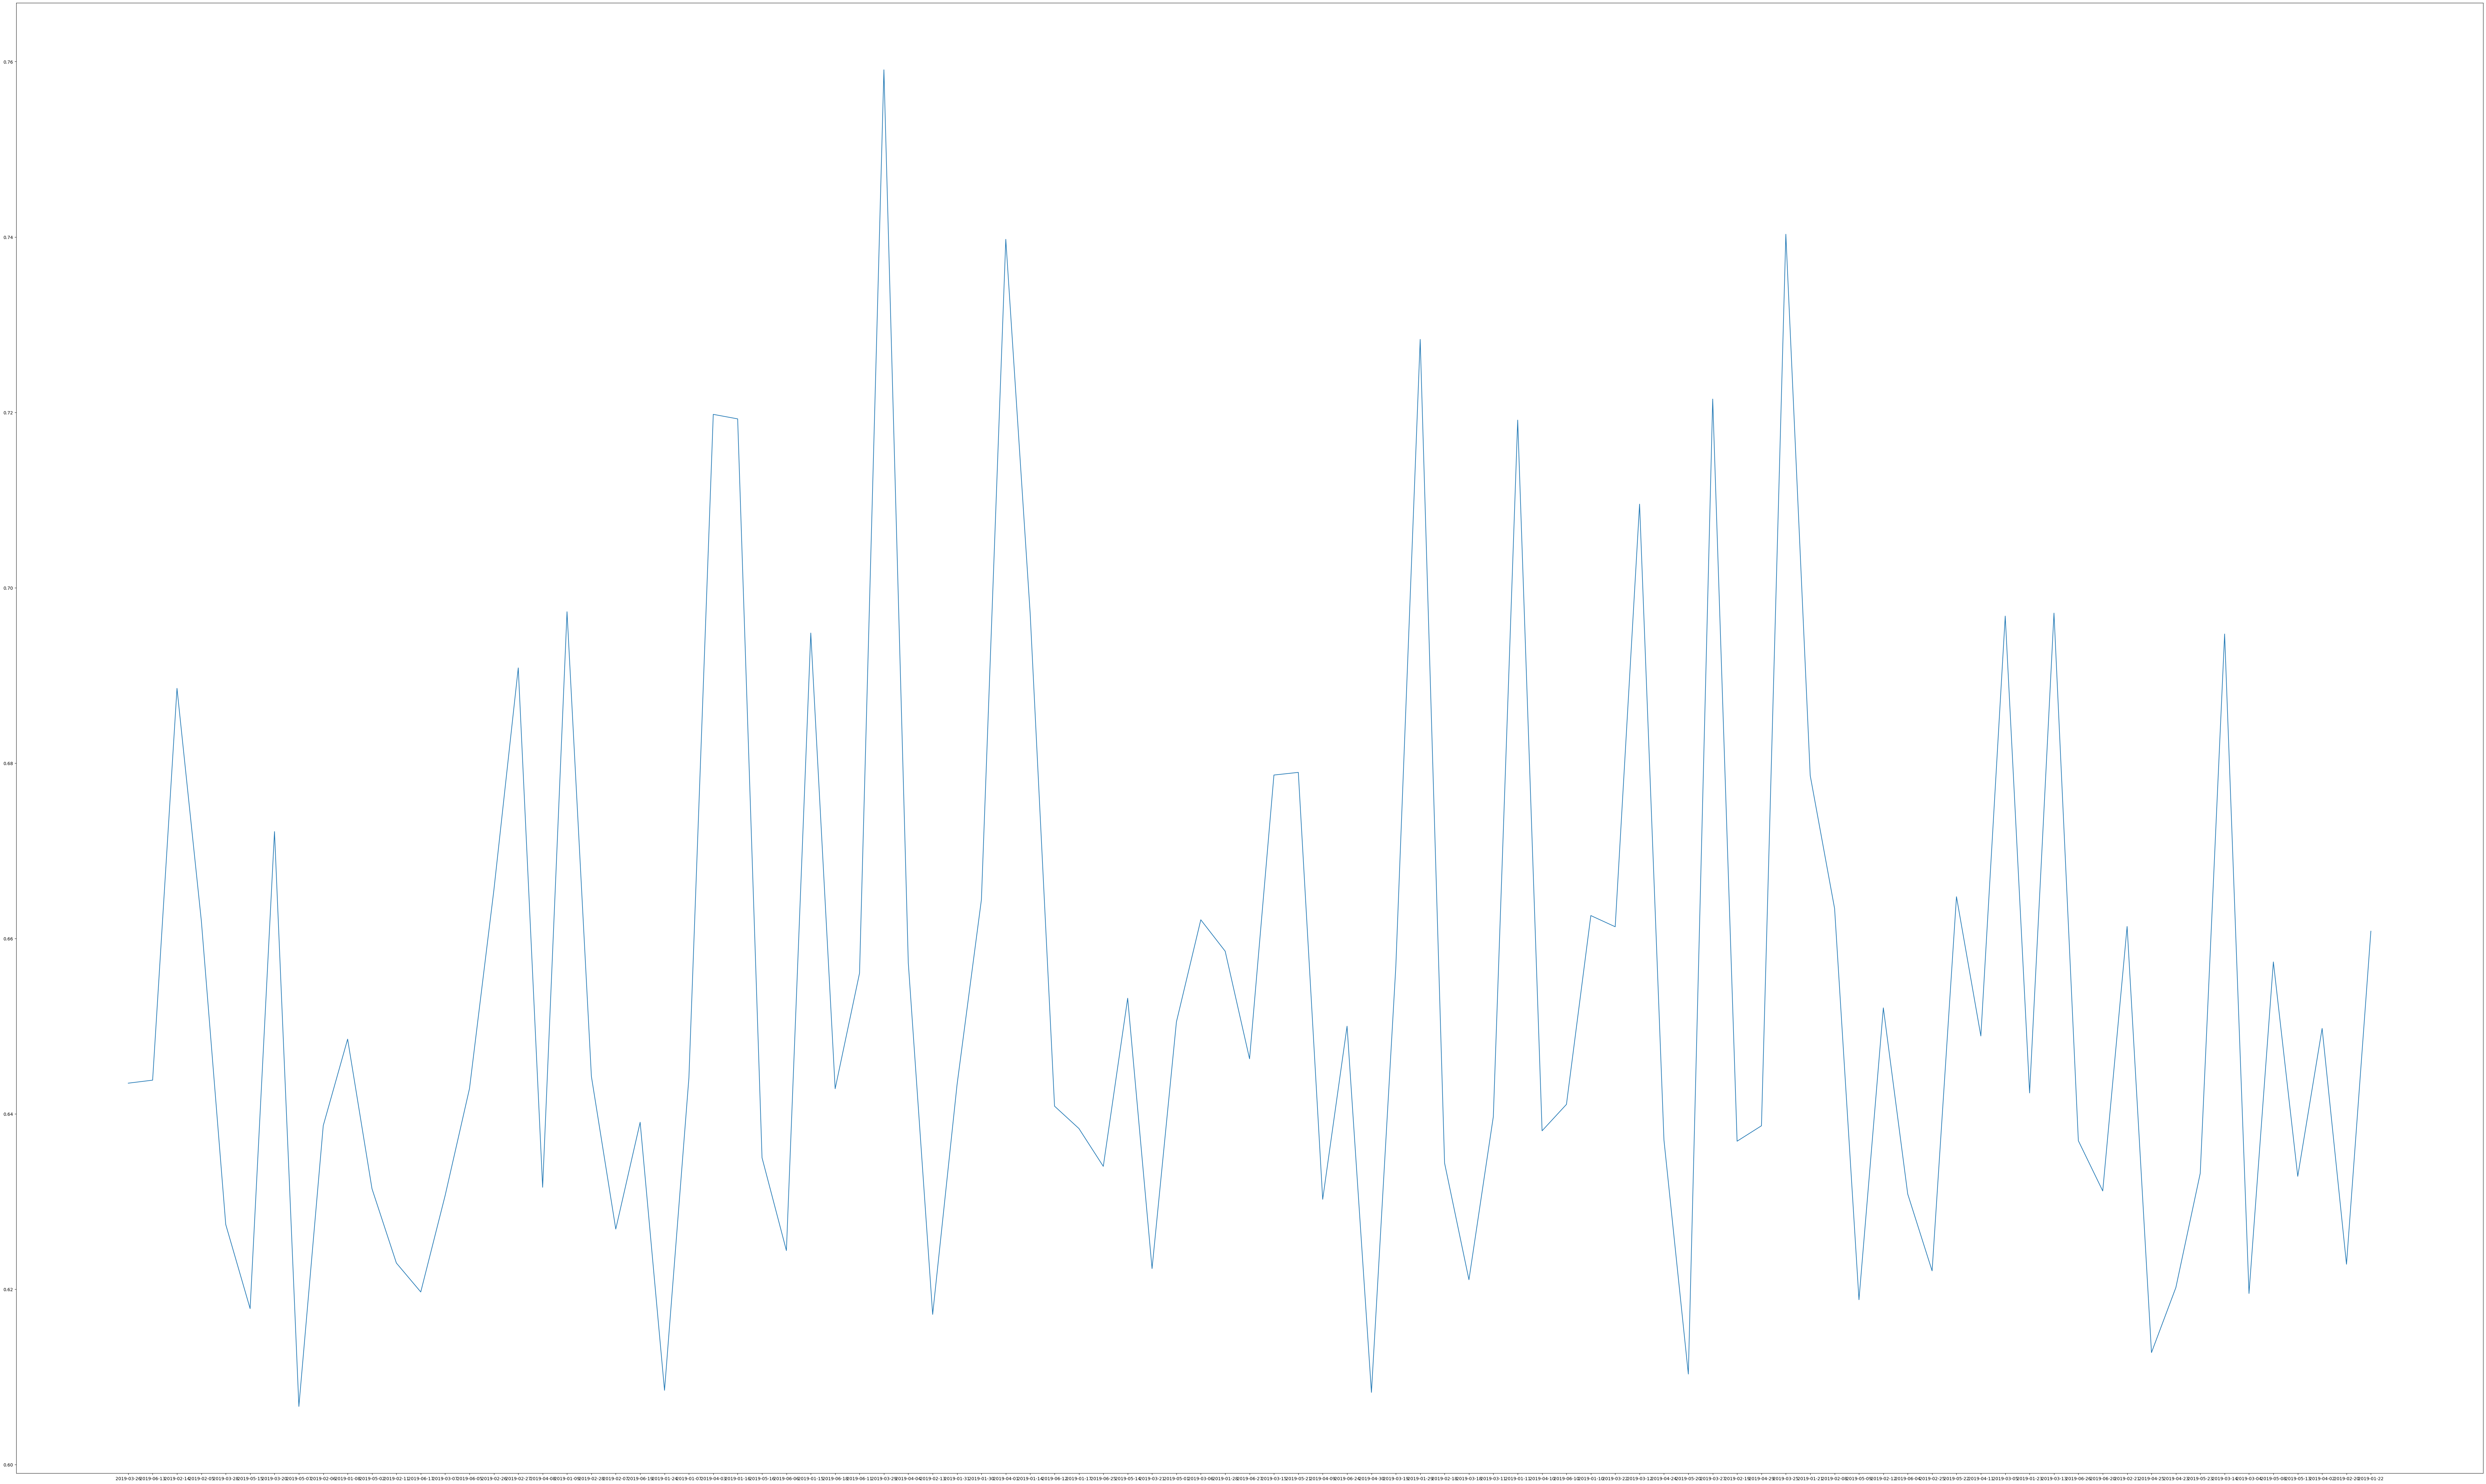

In [58]:
print(dfx.head())
# plot cosine similarity over time
plt.figure(figsize=(100,60))
plt.plot(dfx['Date'], dfx['cos_sim'])
plt.show()